## Feature extraction and manipulation for clustering

In [21]:
from skimage import io
from skimage import feature
from skimage import filters
from skimage.transform import integral_image
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import cv2
from time import sleep

In [2]:
#I previously cropped images to the face
source = '/home/gc1569/Capstone/Cropped_Images/'
feature_list = []
name_list = []

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]

# Resampling function to make arrays the same size
def resample(arr, newLength=1000):
    chunkSize = len(arr)//newLength
    return [np.mean(chunk) for chunk in chunks(arr, chunkSize)][:newLength]


#for each picture, I extract features and store it in a long array of numbers then attach it to a matrix
for i, pic in enumerate([f for f in os.listdir(source) if f.endswith('.jpg')]):
    try:
        imageC = cv2.imread(source + pic)
        image = io.imread(source + pic, as_grey=True)
    except Exception as e:
        print("Unable to open", e)
        continue
    prev = 0
    feature_dict = []  
    
    #some features are 1D some 2D so I flatten the arrays and resample them to the same size for the clustering algorithm
#     feature_dict.append(np.array(
#         cv2.calcHist([imageC], [0,1,2], None, [10,10,10], [0, 256, 0, 256, 0, 256])).flatten()) 
    feature_dict.append(resample(np.array(
        feature.local_binary_pattern(image, 10, 10)).flatten()))
    feature_dict.append(resample(np.array(
        feature.corner_fast(image, n=12, threshold=0.15)).flatten()))
    feature_dict.append(resample(np.array(
        feature.shape_index(image, sigma=1, mode='constant', cval=0)).flatten()))
    HX, HY, HZ = feature.hessian_matrix(image, sigma=1, mode='constant', cval=0, order='xy')
    feature_dict.append(resample(np.array(
        feature.hessian_matrix_eigvals(HX, HY, HZ)[0]).flatten()))
    HX, HY, HZ = feature.structure_tensor(image, sigma=1, mode='constant', cval=0)
    feature_dict.append(resample(np.array(
        feature.structure_tensor_eigvals(HX, HY, HZ)[0]).flatten()))
#     feature_dict.append(resample(1*np.array(
#         feature.canny(image, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False)).flatten()))
#     feature_dict.append(resample(np.array(
#         feature.hog(image, feature_vector=True))))
    feature_dict.append(resample(np.array(
        feature.shape_index(image)).flatten()))
#     feature_dict.append(resample(np.array(
#         feature.blob_dog(image)).flatten()))
#     feature_dict.append(resample(np.array(
#         feature.haar_like_feature(integral_image(image), 0, 0, 5, 5, 'type-3-x')).flatten()))
#     censure = feature.CENSURE()
#     censure.detect(image)    
#     feature_dict.append(resample(np.array(
#         censure.keypoints).flatten()))
    
    
    #getting rid of NaNs by forward filling
    arr = np.array([np.concatenate(feature_dict)])
    if (np.count_nonzero(np.isnan(feature_list)) > 0):
        mask = np.isnan(arr)
        idx = np.where(~mask,np.arange(mask.shape[1]),0)
        np.maximum.accumulate(idx,axis=1, out=idx)
        out = arr[np.arange(idx.shape[0])[:,None], idx]
        feature_list.append(np.nan_to_num(out[0]))
    else:
        feature_list.append(np.nan_to_num(arr[0]))
    name_list.append(source + pic)
    
    if (i%50 == 0):
        print('#', end='')


#

/home/gc1569/anaconda3/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: invalid value encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))
/home/gc1569/anaconda3/lib/python3.6/site-packages/skimage/feature/corner.py:373: RuntimeWarning: divide by zero encountered in true_divide
  return (2.0 / np.pi) * np.arctan((l2 + l1) / (l2 - l1))


################################################################################################################################################################Unable to open cannot identify image file <_io.BufferedReader name='/home/gc1569/Capstone/Cropped_Images/33287153527_0.jpg'>
############Unable to open cannot identify image file <_io.BufferedReader name='/home/gc1569/Capstone/Cropped_Images/17852942235_0.jpg'>
################Unable to open cannot identify image file <_io.BufferedReader name='/home/gc1569/Capstone/Cropped_Images/36174036846_0.jpg'>
#############################Unable to open cannot identify image file <_io.BufferedReader name='/home/gc1569/Capstone/Cropped_Images/41273768897_0.jpg'>
###

In [3]:
#pickling so that results can be used later
df = pd.DataFrame(feature_list)
df2 = pd.DataFrame(name_list)
df2.to_pickle('/home/gc1569/Capstone/Image_Features/namelist.pickle')
df.to_pickle('/home/gc1569/Capstone/Image_Features/featuresflat.pickle')
print('All features extracted and pickled file')

All features extracted and pickled file


## Dimensionality reduction

(11011, 6000)


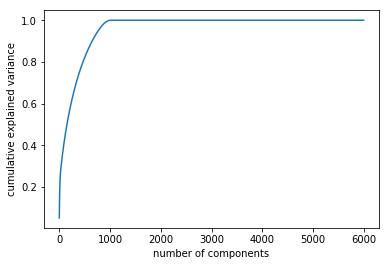

In [18]:
df = pd.read_pickle('/home/gc1569/Capstone/Image_Features/featuresflat.pickle')
name_list = list(pd.read_pickle('/home/gc1569/Capstone/Image_Features/namelist.pickle')[0])
print(df.shape)
df = df.values.tolist()
from sklearn.decomposition import PCA
pca = PCA().fit(df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

In [7]:
pca = PCA(1000)
projected = pca.fit_transform(df) 
projected.shape

(11011, 1000)

## Hierarchical clustering and dendogram

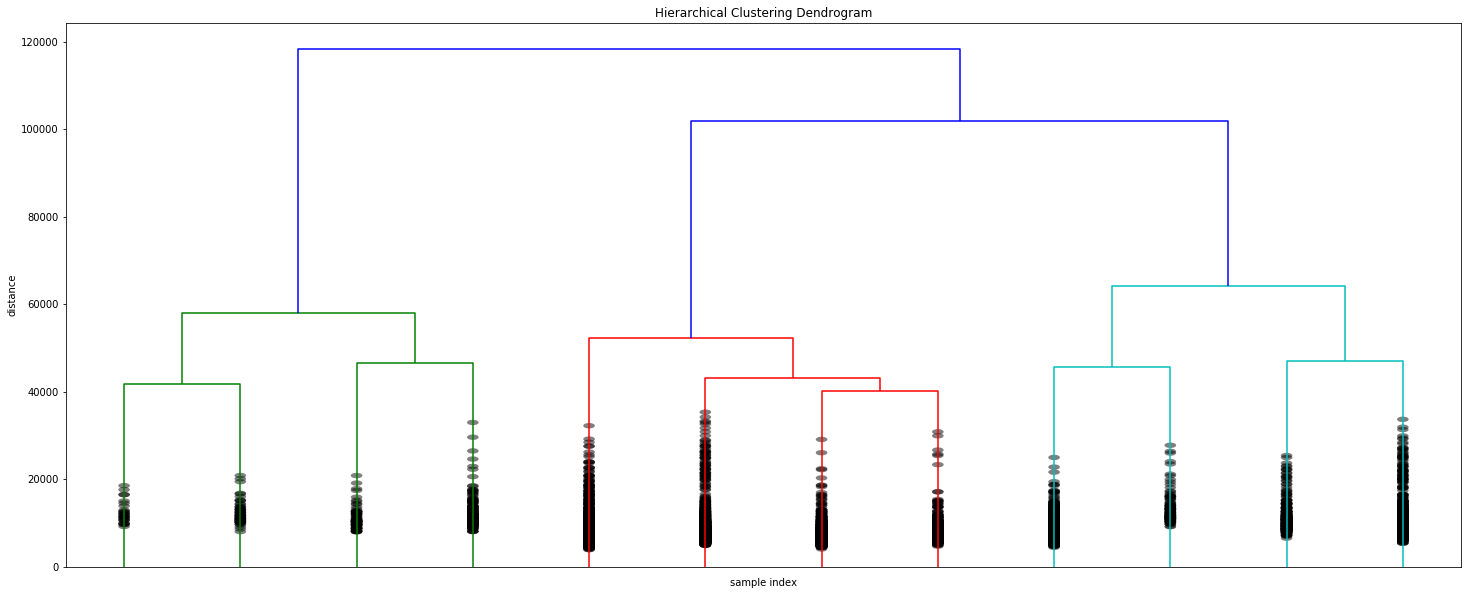

2    7658
4    1772
3    1234
1     347
dtype: int64

In [8]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster


Z = linkage(projected, 'ward')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()

no_clusters = 4
clusters = fcluster(Z, no_clusters, criterion='maxclust')
pd.Series(clusters).value_counts()


## Visualizing the clusters by taking a random sample of its contained images

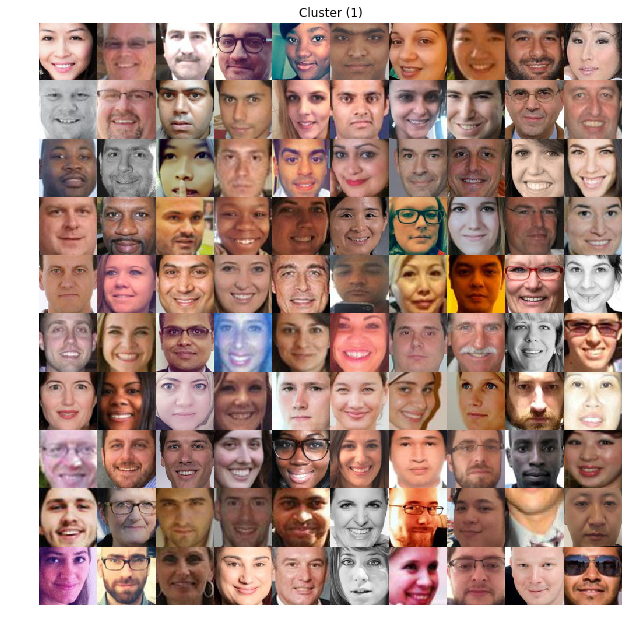

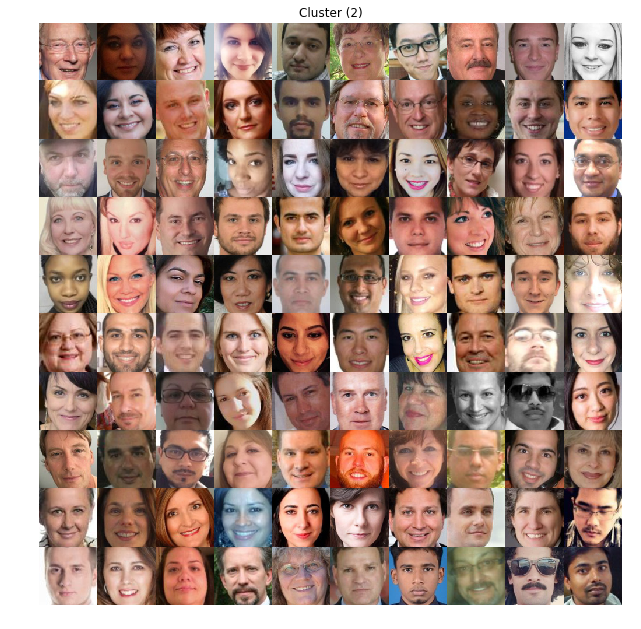

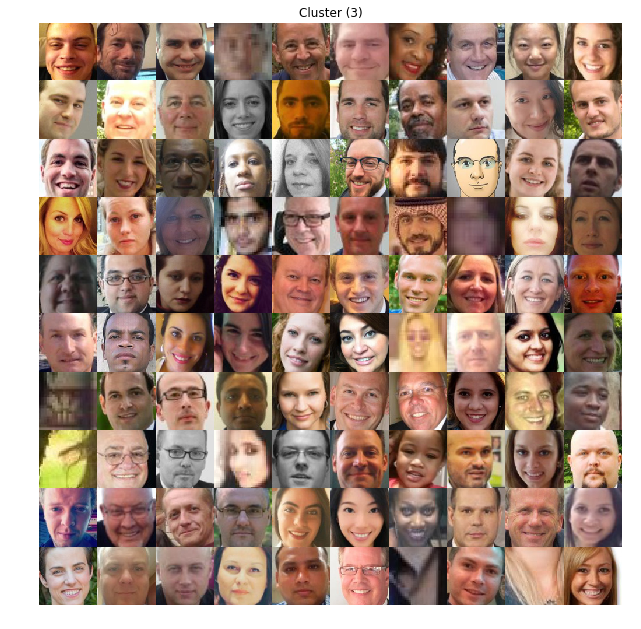

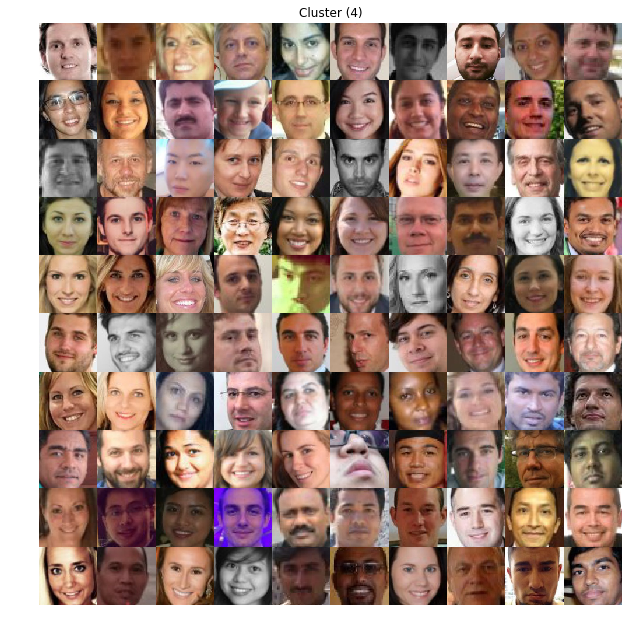

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

def calc_tile(files):
    new_im = Image.new('RGB', (1000,1000), (100,100,100))
    index = 0
    for i in range(0,1000,100):
        for j in range(0,1000,100):
            try:
                image = Image.open(files[index])
                
            except:
                break
            width  = image.size[0]
            height = image.size[1]

            aspect = width / float(height)

            ideal_width = 100
            ideal_height = 100

            ideal_aspect = ideal_width / float(ideal_height)

            if aspect > ideal_aspect:
                # Then crop the left and right edges:
                new_width = int(ideal_aspect * height)
                offset = (width - new_width) / 2
                resize = (offset, 0, width - offset, height)
            else:
                # ... crop the top and bottom:
                new_height = int(width / ideal_aspect)
                offset = (height - new_height) / 2
                resize = (0, offset, width, height - offset)

            thumb = image.crop(resize).resize((ideal_width, ideal_height), Image.ANTIALIAS)
            new_im.paste(thumb, (i,j))
            index += 1
    return new_im


images = []
cols = 1
for i in range(1, no_clusters+1):
    vis = []
    for ind, k in enumerate(clusters):
        if (k == i): 
            vis.append(name_list[ind])
    images.append(calc_tile(vis))    


for n, (image, title) in enumerate(zip(images, titles)):
    fig = plt.figure()
    a = fig.add_subplot(cols, np.ceil(n_images), 1)
    plt.imshow(image)
    a.set_title(title)
    plt.axis('off')
    fig.set_size_inches(np.array(fig.get_size_inches()) * 8)
    plt.show()
    sleep(2)